# Hierarchical Predator Prey modelling with varying initial conditions

The Lotka-Volterra predator-prey model is the archetypical model for dynamical systems, depicting the fluctuating population development of the dynamical system. 
It is simple enough to fit parameters and estimate their uncertainty in a single replicate. But what if there was some environmental fluctuation we wanted 

In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz

import jax
jax.config.update("jax_enable_x64", True)

from pymob import Config
from pymob.sim.parameters import Param

from lotka_volterra_case_study.sim import HierarchicalSimulation

In [2]:
# import case study and simulation

config = Config("../scenarios/lotka_volterra_hierarchical_hyperpriors/settings.cfg")
config.case_study.package = "../.."
config.case_study.scenario = "lotka_volterra_hierarchical_vaying_y0"

sim = HierarchicalSimulation(config)
sim.setup()

# sim.initialize_from_script()

MinMaxScaler(variable=rabbits, min=0.0, max=1329.0)
MinMaxScaler(variable=wolves, min=0.0, max=1019.0)
Results directory exists at '/home/flo-schu/projects/pymob/case_studies/lotka_volterra_case_study/results/lotka_volterra_hierarchical_vaying_y0'.
Scenario directory exists at '/home/flo-schu/projects/pymob/case_studies/lotka_volterra_case_study/scenarios/lotka_volterra_hierarchical_vaying_y0'.


## Investigate the structure of $y_0$

For simulating our artificial data (`hierarchical_model.ipynb`), we assumed some initial values of $y_0$. The $y_0$ values were generated from a uniform distribution between 2 and 15 for wolves and a uniform distribution between 35 and 70. Then, after simulating the observations, a poisson noise model was added on top of the deterministic simulation.

So far, we have assumed that the noisy observation at $t=0$ are the true initial values for the simulation.

To demonstrate this effect. We look at two trajectories that have different starting values

<xarray.Dataset>
Dimensions:               (id: 120, time: 100)
Coordinates:
  * id                    (id) int32 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
  * time                  (time) float64 0.0 0.101 0.202 ... 9.798 9.899 10.0
    rabbit_species        (id) object 'Cottontail' 'Cottontail' ... 'Jackrabbit'
    experiment            (id) object '2010' '2010' '2010' ... '2012' '2012'
    rabbit_species_index  (id) int64 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    experiment_index      (id) int64 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2
Data variables:
    rabbits               (id, time) float32 50.0 55.2 60.94 ... 27.61 29.72
    wolves                (id, time) float32 1.0 1.023 1.052 ... 13.67 13.65

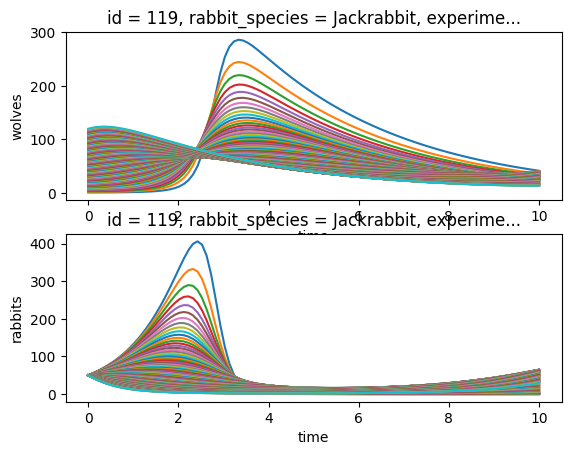

In [3]:
# expand time coordinates and constrain index coordinates for demonstration purposes
sim.coordinates["time"] = np.linspace(0,10,100)
# sim.coordinates["id"] = np.arange(0, 3)

sim.dispatch_constructor()
# TODO: Only partially replace the y0 values (like in theta)
e = sim.dispatch(
    theta={"alpha": 1, "beta": 0.02}, 
    y0={"rabbits": [50], "wolves":np.arange(1,121)}
)
e()

fig, (ax1, ax2) = plt.subplots(2,1)
for i in sim.coordinates["id"]:
    e.results.sel(id=i).wolves.plot(ax=ax1, label=f"id={i}")
    e.results.sel(id=i).rabbits.plot(ax=ax2, label=f"id={i}")

# plt.legend()

e.results

In this *mild* case, only the starting population of the rabbits vary (56, 44), while wolves are identical. Despite, we see quite some differences in the dynamic, although the model parameters are the same.

We need to esimtate the true $y_0$ values to remove this bias.

Assuming that $y_0$ is not known, means we also have to define a prior for the starting values and draw realizations of the starting population from a distribution.

This gives us two approaches:
1. We know nothing about the true initial population. This would result in a Uniform prior over the entire span of the data and then add some more, because the true value could lie above or below the range (in our case it will lie only above).
2. We know the observed $y_0$ value and use this as a mean for a prior distribution and assume the error of this prior is the same for each initial value accross all experiments. This can of course become arbitrarily complex, where we could assume that the error on the initial value is different from year to year or species to species, but saying the error on the prior distribution for y0 is always the same seems to be a good first approximation (and we know it's true.)

In order to not make our lives harder for an artificial problem, lets take a look at the distributions of the starting values.


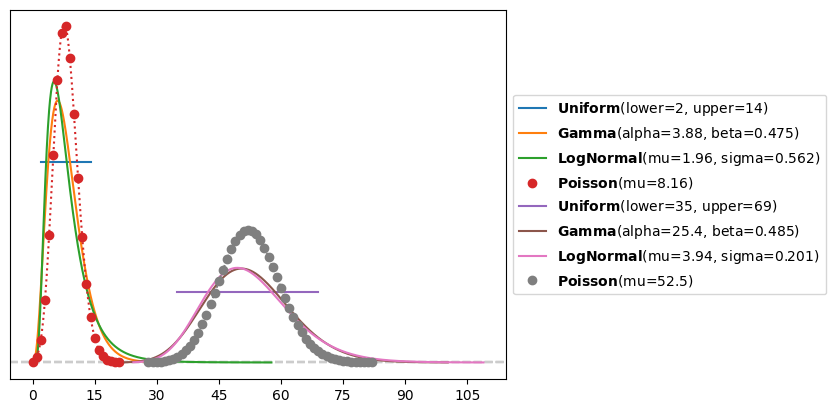

In [4]:
y0 = sim.parse_input("y0", reference_data=sim.observations, drop_dims=["time"])

unif_wolves = pz.Uniform()
pois_wolves = pz.Poisson()
lnorm_wolves = pz.LogNormal()
gamma_wolves = pz.Gamma()

_, ax = pz.mle([pois_wolves, unif_wolves, lnorm_wolves, gamma_wolves], y0["wolves"], plot=4)

unif_rabbits = pz.Uniform()
pois_rabbits = pz.Poisson()
lnorm_rabbits = pz.LogNormal()
gamma_rabbits = pz.Gamma()
_, ax = pz.mle([pois_rabbits, unif_rabbits, lnorm_wolves, gamma_rabbits], y0["rabbits"], plot=4)

## Fitting the initial values

In [ ]:
sim.config.jaxsolver.diffrax_solver = "Dopri5"
sim.config.jaxsolver.atol = 1e-12
sim.config.jaxsolver.rtol = 1e-10

In [7]:
wolves_y0 = Param(value=8, dims=("id",), prior="lognorm(scale=4,s=0.6)")
rabbits_y0 = Param(value=60, dims=("id",), prior="lognorm(scale=53,s=0.2)")

sim.config.model_parameters.wolves_y0 = wolves_y0
sim.config.model_parameters.rabbits_y0 = rabbits_y0
sim.config.model_parameters.beta.prior = "lognorm(scale=0.02,s=2)"
sim.config.model_parameters.alpha_species_mu.prior = "halfnorm(scale=5)"
sim.config.model_parameters.alpha_species_sigma.prior = "halfnorm(scale=1)"
sim.config.model_parameters.alpha_species.prior = "lognorm(scale=[alpha_species_mu],s=alpha_species_sigma)"

Jax 64 bit mode: False
Absolute tolerance: 0.001


/home/flo-schu/miniconda3/envs/lotka-volterra/lib/python3.11/site-packages/pymob/sim/plot.py:155: UserWarning: There were 4 NaN or Inf values in the idata group 'prior_predictive'. See Simulation.inf_preds for a mask with the coordinates.
  warnings.warn(
/home/flo-schu/miniconda3/envs/lotka-volterra/lib/python3.11/site-packages/pymob/sim/plot.py:155: UserWarning: There were 4 NaN or Inf values in the idata group 'prior_predictive'. See Simulation.inf_preds for a mask with the coordinates.
  warnings.warn(


{'alpha_species_mu': HalfNormalTrans(scale=5, dims=('rabbit_species=2',), obs=None),
 'alpha_species_sigma': HalfNormalTrans(scale=1, dims=(), obs=None),
 'alpha_species': LogNormalTrans(loc=[alpha_species_mu], scale=alpha_species_sigma, dims=('experiment=3', 'rabbit_species=2'), obs=None),
 'alpha_sigma': HalfNormalTrans(scale=1, dims=(), obs=None),
 'alpha': LogNormalTrans(scale=alpha_sigma, loc=alpha_species[experiment_index, rabbit_species_index], dims=('id=120',), obs=None),
 'beta': LogNormalTrans(loc=0.02, scale=2, dims=(), obs=None),
 'wolves_y0': LogNormalTrans(loc=4, scale=0.6, dims=('id=120',), obs=None),
 'rabbits_y0': LogNormalTrans(loc=53, scale=0.2, dims=('id=120',), obs=None)}

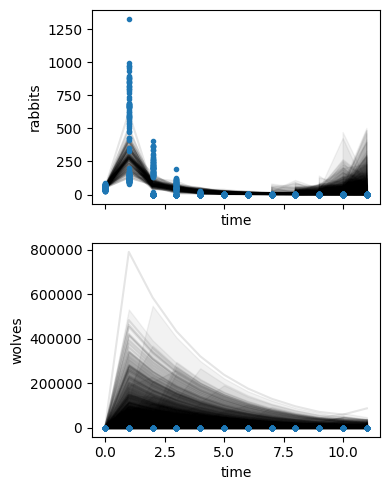

In [8]:
sim.reset_coordinate("time")
sim.config.inference_numpyro.kernel = "svi"
sim.dispatch_constructor()
sim.set_inferer("numpyro")

sim.config.inference.n_predictions = 50
sim.prior_predictive_checks()
sim.inferer.prior 

                       Trace Shapes:          
                        Param Sites:          
                       Sample Sites:          
   alpha_species_mu_normal_base dist       2 |
                               value       2 |
alpha_species_sigma_normal_base dist         |
                               value         |
      alpha_species_normal_base dist   3   2 |
                               value   3   2 |
        alpha_sigma_normal_base dist         |
                               value         |
              alpha_normal_base dist     120 |
                               value     120 |
               beta_normal_base dist         |
                               value         |
          wolves_y0_normal_base dist     120 |
                               value     120 |
         rabbits_y0_normal_base dist     120 |
                               value     120 |
                    rabbits_obs dist 120  12 |
                               value 120  12 |
             

100%|██████████| 5000/5000 [01:26<00:00, 57.68it/s, init loss: 5719281.5000, avg. loss [4751-5000]: nan]         
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]        1.481  0.488   0.603    2.415      0.011    0.008    1879.0   
alpha[1]        1.272  0.392   0.567    2.007      0.009    0.006    1867.0   
alpha[2]        1.238  0.382   0.574    1.970      0.009    0.006    1835.0   
alpha[3]        1.260  0.387   0.571    1.992      0.009    0.006    1849.0   
alpha[4]        1.424  0.458   0.578    2.275      0.011    0.007    1866.0   
...               ...    ...     ...      ...        ...      ...       ...   
wolves_y0[115]  2.893  0.367   2.230    3.590      0.008    0.006    2108.0   
wolves_y0[116]  5.655  0.541   4.624    6.640      0.012    0.009    2013.0   
wolves_y0[117]  4.000  0.433   3.192    4.796      0.009    0.007    2085.0   
wolves_y0[118]  3.564  0.378   2.877    4.278      0.009    0.006    1731.0   
wolves_y0[119]  5.302  0.543   4.281    6.278      0.012    0.009    1987.0   

                ess_tail  r_hat  
alpha[0]         

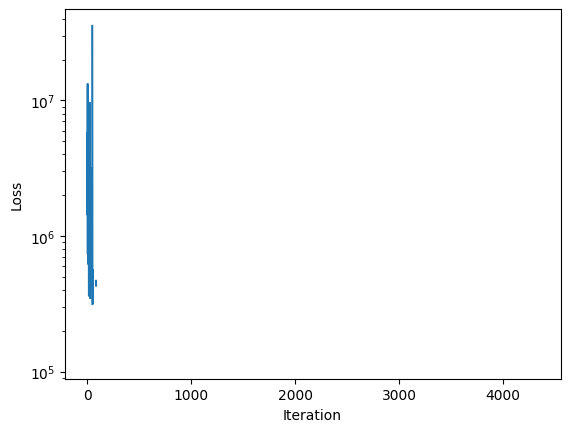

In [9]:
if True:
    sim.config.inference_numpyro.svi_iterations = 5000
    sim.config.inference_numpyro.svi_learning_rate = 0.01

    sim.inferer.run()
    sim.inferer.store_results(f"{sim.output_path}/numpyro_svi_posterior.nc")
else:
    sim.inferer.load_results("numpyro_svi_posterior.nc")

In [10]:
sim.inferer.idata.posterior.beta.mean(("chain", "draw"))

<xarray.DataArray 'beta' ()>
array(0.03206292, dtype=float32)

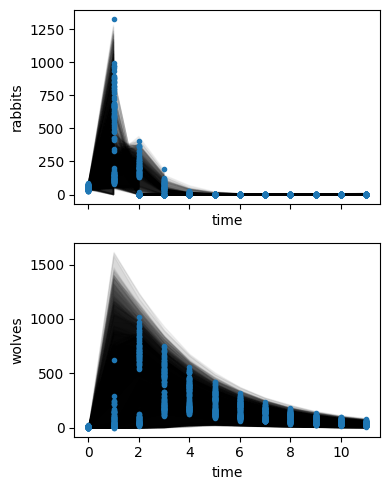

In [11]:
sim.posterior_predictive_checks()

In [11]:
az.hdi(sim.inferer.idata.posterior["beta"], hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    beta     (hdi) float64 0.01709 0.01786

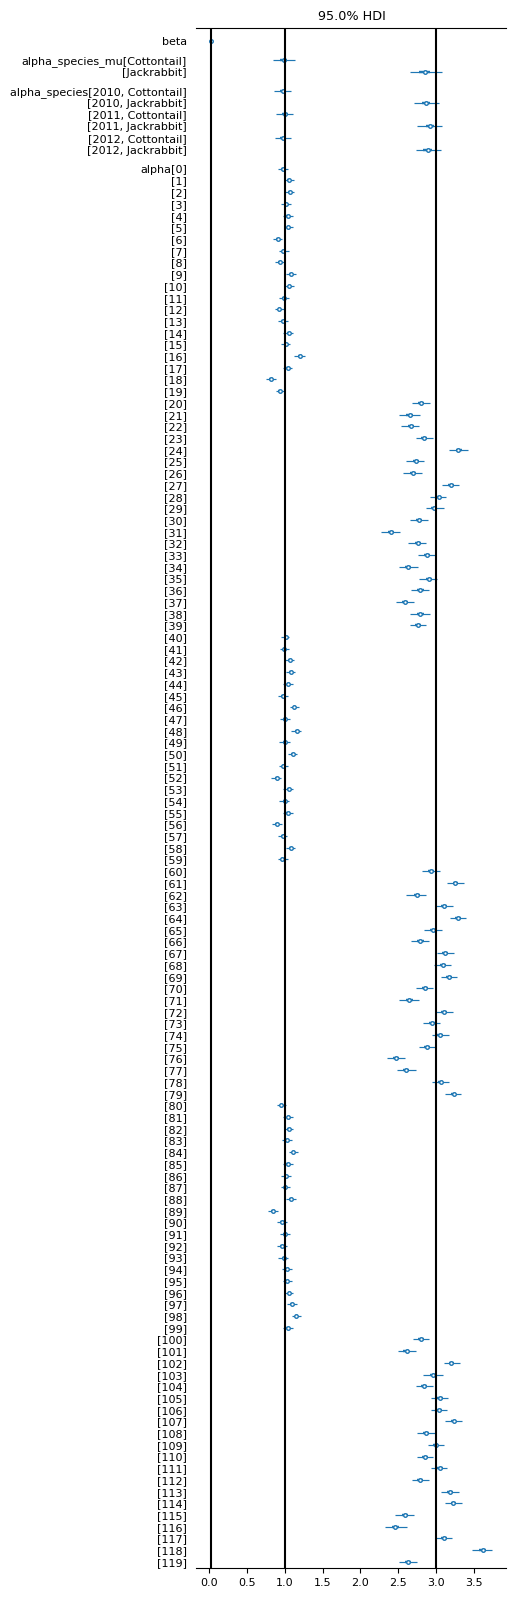

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,20))

az.plot_forest(
    data=[sim.inferer.idata.posterior], 
    var_names=["beta", "alpha_species_mu", "alpha_species", "alpha"],
    ax=ax1,
    combined=True,
    hdi_prob=0.95,
    textsize=8
)
ax1.vlines(0.017648710084435453,*ax1.get_ylim(), color="black")
ax1.vlines(1,*ax1.get_ylim(), color="black")
ax1.vlines(3,*ax1.get_ylim(), color="black")


It seems we are nailing it already. The parameter estimates provided by SVI contain the true values in their estimate. Yay 🎉
We see that the alpha values of the *Jackrabbit* species vary more than the *Cottontail* alphas. This is caused by using lognormal priors for generating the alpha values for the IDs.
The underestimation of the alpha_species_mu posterior parameter esimtate of the Jackrabbit species could originate from stochasticity in the data generation (drawing of alpha values).
Parameter estimation was also successfully achieved from pretty uninformative distributions. This also is a success
The downside is that NUTS takes a long time.

The only thing up next is using our initially observed values as prior means for the initial values

/home/flo-schu/projects/pymob/pymob/sim/plot.py:155: UserWarning: There were 3 NaN or Inf values in the idata group 'prior_predictive'. See Simulation.inf_preds for a mask with the coordinates.
  warnings.warn(
/home/flo-schu/projects/pymob/pymob/sim/plot.py:155: UserWarning: There were 3 NaN or Inf values in the idata group 'prior_predictive'. See Simulation.inf_preds for a mask with the coordinates.
  warnings.warn(


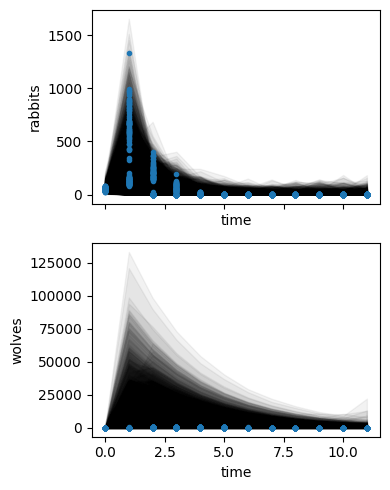

In [33]:
rabbits_y0_mu = str(sim.model_parameters["y0"]["rabbits"].values.tolist()).replace(" ", "")
wolves_y0_mu = str(sim.model_parameters["y0"]["wolves"].values.tolist()).replace(" ", "")
sim.config.model_parameters.wolves_y0.prior = f"lognorm(scale={wolves_y0_mu},s=0.5)"
sim.config.model_parameters.rabbits_y0.prior = f"lognorm(scale={rabbits_y0_mu},s=0.5)"
sim.set_inferer("numpyro")
sim.prior_predictive_checks()
sim.inferer.prior

                       Trace Shapes:          
                        Param Sites:          
                       Sample Sites:          
   alpha_species_mu_normal_base dist       2 |
                               value       2 |
alpha_species_sigma_normal_base dist         |
                               value         |
      alpha_species_normal_base dist   3   2 |
                               value   3   2 |
        alpha_sigma_normal_base dist         |
                               value         |
              alpha_normal_base dist     120 |
                               value     120 |
               beta_normal_base dist         |
                               value         |
          wolves_y0_normal_base dist     120 |
                               value     120 |
         rabbits_y0_normal_base dist     120 |
                               value     120 |
                    rabbits_obs dist 120  12 |
                               value 120  12 |
             

100%|██████████| 2000/2000 [02:47<00:00, 11.96it/s, init loss: 72264840585.0052, avg. loss [1901-2000]: 4630.1432]  
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]         1.010  0.036   0.944    1.079      0.001    0.001    1924.0   
alpha[1]         1.112  0.037   1.038    1.175      0.001    0.001    1887.0   
alpha[2]         1.093  0.038   1.019    1.163      0.001    0.001    2012.0   
alpha[3]         1.088  0.036   1.017    1.151      0.001    0.001    1524.0   
alpha[4]         1.048  0.033   0.989    1.110      0.001    0.001    2010.0   
...                ...    ...     ...      ...        ...      ...       ...   
wolves_y0[115]  14.685  1.258  12.317   16.990      0.029    0.021    1891.0   
wolves_y0[116]  13.725  1.302  11.381   16.144      0.029    0.021    1984.0   
wolves_y0[117]  11.830  0.881  10.236   13.474      0.020    0.014    1948.0   
wolves_y0[118]   3.966  0.260   3.486    4.430      0.006    0.004    1842.0   
wolves_y0[119]   7.461  0.675   6.157    8.634      0.016    0.011    1823.0   

                ess_tail  r_hat  
alpha

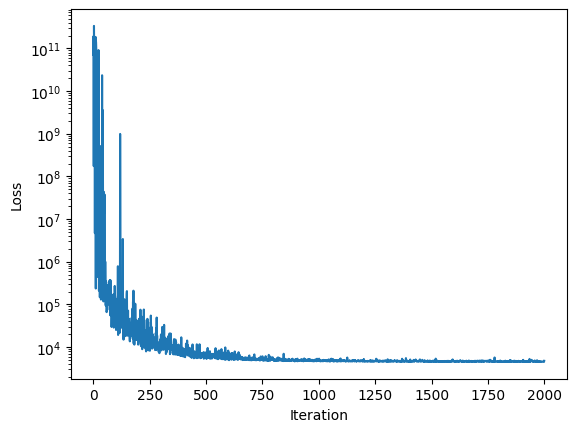

In [35]:
sim.inferer.run()

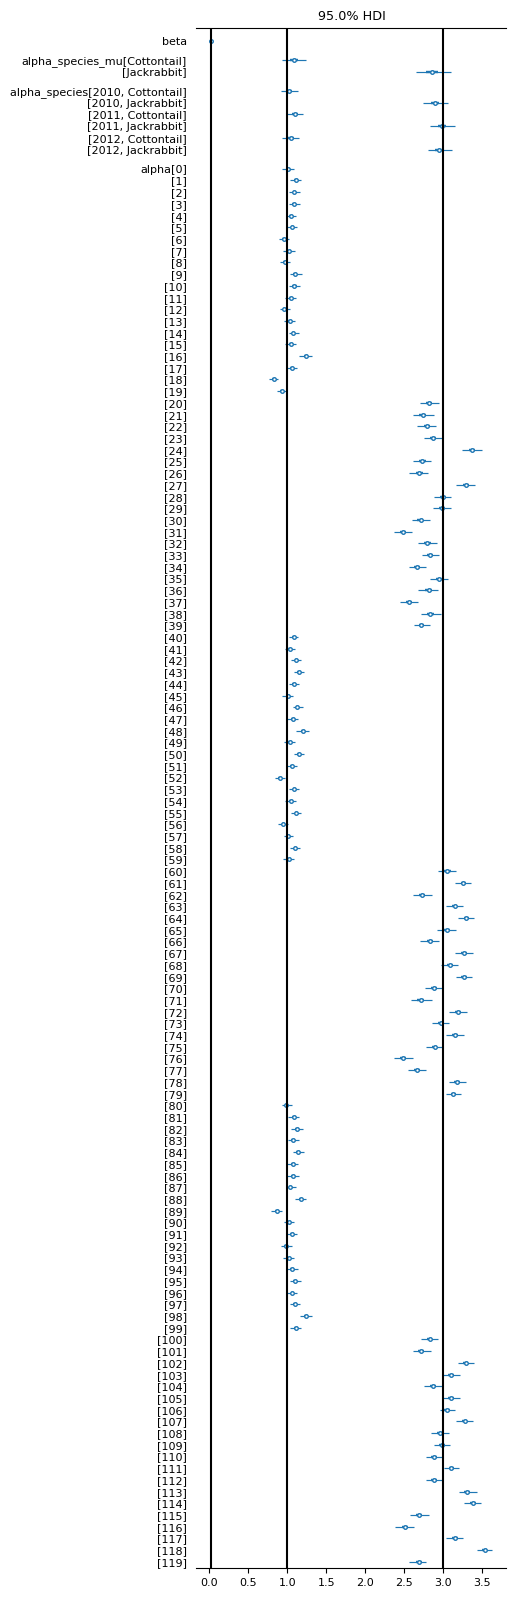

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,20))

az.plot_forest(
    data=[sim.inferer.idata.posterior], 
    var_names=["beta", "alpha_species_mu", "alpha_species", "alpha"],
    ax=ax1,
    combined=True,
    hdi_prob=0.95,
    textsize=8
)
ax1.vlines(0.017648710084435453,*ax1.get_ylim(), color="black")
ax1.vlines(1,*ax1.get_ylim(), color="black")
ax1.vlines(3,*ax1.get_ylim(), color="black")


The relevant population parameters alpha[Cottontail], alpha[Jackrabbit] and beta[Wolves] are identified with good precision and uncertainty. Using the prior information for the starting values is a good idea.

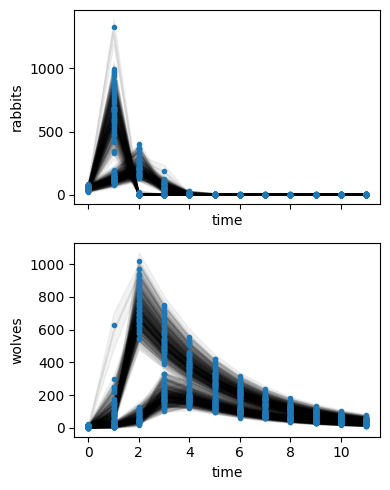

In [40]:
sim.posterior_predictive_checks()

In [41]:
sim.config.case_study.scenario = "lotka_volterra_hierarchical_final"
sim.config.create_directory("scenario", force=True)
sim.config.save(force=True)

Scenario directory created at '/home/flo-schu/projects/pymob/case_studies/lotka_volterra_case_study/scenarios/lotka_volterra_hierarchical_final'.
